# Árboles de decisión

Un árbol de decisión es un mapa de los posibles resultados de una serie de decisiones relacionadas. Permite que un individuo o una organización comparen posibles acciones entre sí según sus costos, probabilidades y beneficios. Se pueden usar para dirigir un intercambio de ideas informal o trazar un algoritmo que anticipe matemáticamente la mejor opción.

## Implementación

In [308]:
# Data wrangling 
import pandas as pd 

# Array math
import numpy as np 

# Quick value count calculator
from collections import Counter


class Node: 
    """
    Class for creating the nodes for a decision tree 
    """
    def __init__(
        self, 
        Y: list,
        X: pd.DataFrame,
        min_samples_split=None,
        max_depth=None,
        depth=None,
        node_type=None,
        rule=None
    ):
        # Saving the data to the node 
        self.Y = Y 
        self.X = X

        # Saving the hyper parameters
        self.min_samples_split = min_samples_split if min_samples_split else 20
        self.max_depth = max_depth if max_depth else 5

        # Default current depth of node 
        self.depth = depth if depth else 0

        # Extracting all the features
        self.features = list(self.X.columns)

        # Type of node 
        self.node_type = node_type if node_type else 'root'

        # Rule for spliting 
        self.rule = rule if rule else ""

        # Calculating the counts of Y in the node 
        self.counts = Counter(Y)

        # Getting the GINI impurity based on the Y distribution
        self.gini_impurity = self.get_GINI()

        # Sorting the counts and saving the final prediction of the node 
        counts_sorted = list(sorted(self.counts.items(), key=lambda item: item[1]))

        # Getting the last item
        yhat = None
        if len(counts_sorted) > 0:
            yhat = counts_sorted[-1][0]

        # Saving to object attribute. This node will predict the class with the most frequent class
        self.yhat = yhat 

        # Saving the number of observations in the node 
        self.n = len(Y)

        # Initiating the left and right nodes as empty nodes
        self.left = None 
        self.right = None 

        # Default values for splits
        self.best_feature = None 
        self.best_value = None 

    @staticmethod
    def GINI_impurity(y1_count: int, y2_count: int) -> float:
        """
        Given the observations of a binary class calculate the GINI impurity
        """
        # Ensuring the correct types
        if y1_count is None:
            y1_count = 0

        if y2_count is None:
            y2_count = 0

        # Getting the total observations
        n = y1_count + y2_count
        
        # If n is 0 then we return the lowest possible gini impurity
        if n == 0:
            return 0.0

        # Getting the probability to see each of the classes
        p1 = y1_count / n
        p2 = y2_count / n
        
        # Calculating GINI 
        gini = 1 - (p1 ** 2 + p2 ** 2)
        
        # Returning the gini impurity
        return gini

    @staticmethod
    def ma(x: np.array, window: int) -> np.array:
        """
        Calculates the moving average of the given list. 
        """
        return np.convolve(x, np.ones(window), 'valid') / window

    def get_GINI(self):
        """
        Function to calculate the GINI impurity of a node 
        """
        # Getting the 0 and 1 counts
        y1_count, y2_count = self.counts.get(0, 0), self.counts.get(1, 0)

        # Getting the GINI impurity
        return self.GINI_impurity(y1_count, y2_count)

    def best_split(self) -> tuple:
        """
        Given the X features and Y targets calculates the best split 
        for a decision tree
        """
        # Creating a dataset for spliting
        df = self.X.copy()
        df['Y'] = self.Y

        # Getting the GINI impurity for the base input 
        GINI_base = self.get_GINI()

        # Finding which split yields the best GINI gain 
        max_gain = 0

        # Default best feature and split
        best_feature = None
        best_value = None

        for feature in self.features:
            # Droping missing values
            Xdf = df.dropna().sort_values(feature)

            # Sorting the values and getting the rolling average
            xmeans = self.ma(Xdf[feature].unique(), 2)

            for value in xmeans:
                # Spliting the dataset 
                left_counts = Counter(Xdf[Xdf[feature]<value]['Y'])
                right_counts = Counter(Xdf[Xdf[feature]>=value]['Y'])

                # Getting the Y distribution from the dicts
                y0_left, y1_left, y0_right, y1_right = left_counts.get(0, 0), left_counts.get(1, 0), right_counts.get(0, 0), right_counts.get(1, 0)

                # Getting the left and right gini impurities
                gini_left = self.GINI_impurity(y0_left, y1_left)
                gini_right = self.GINI_impurity(y0_right, y1_right)

                # Getting the obs count from the left and the right data splits
                n_left = y0_left + y1_left
                n_right = y0_right + y1_right

                # Calculating the weights for each of the nodes
                w_left = n_left / (n_left + n_right)
                w_right = n_right / (n_left + n_right)

                # Calculating the weighted GINI impurity
                wGINI = w_left * gini_left + w_right * gini_right

                # Calculating the GINI gain 
                GINIgain = GINI_base - wGINI

                # Checking if this is the best split so far 
                if GINIgain > max_gain:
                    best_feature = feature
                    best_value = value 

                    # Setting the best gain to the current one 
                    max_gain = GINIgain

        return (best_feature, best_value)

    def grow_tree(self):
        """
        Recursive method to create the decision tree
        """
        # Making a df from the data 
        df = self.X.copy()
        df['Y'] = self.Y

        # If there is GINI to be gained, we split further 
        if (self.depth < self.max_depth) and (self.n >= self.min_samples_split):

            # Getting the best split 
            best_feature, best_value = self.best_split()

            if best_feature is not None:
                # Saving the best split to the current node 
                self.best_feature = best_feature
                self.best_value = best_value

                # Getting the left and right nodes
                left_df, right_df = df[df[best_feature]<=best_value].copy(), df[df[best_feature]>best_value].copy()

                # Creating the left and right nodes
                left = Node(
                    left_df['Y'].values.tolist(), 
                    left_df[self.features], 
                    depth=self.depth + 1, 
                    max_depth=self.max_depth, 
                    min_samples_split=self.min_samples_split, 
                    node_type='left_node',
                    rule=f"{best_feature} <= {round(best_value, 3)}"
                    )

                self.left = left 
                self.left.grow_tree()

                right = Node(
                    right_df['Y'].values.tolist(), 
                    right_df[self.features], 
                    depth=self.depth + 1, 
                    max_depth=self.max_depth, 
                    min_samples_split=self.min_samples_split,
                    node_type='right_node',
                    rule=f"{best_feature} > {round(best_value, 3)}"
                    )

                self.right = right
                self.right.grow_tree()

    def print_info(self, width=4):
        """
        Method to print the infromation about the tree
        """
        # Defining the number of spaces 
        const = int(self.depth * width ** 1.5)
        spaces = "-" * const
        
        if self.node_type == 'root':
            print("Root")
        else:
            print(f"|{spaces} Split rule: {self.rule}")
        print(f"{' ' * const}   | GINI impurity of the node: {round(self.gini_impurity, 2)}")
        print(f"{' ' * const}   | Class distribution in the node: {dict(self.counts)}")
        print(f"{' ' * const}   | Predicted class: {self.yhat}")   

    def print_tree(self):
        """
        Prints the whole tree from the current node to the bottom
        """
        self.print_info() 
        
        if self.left is not None: 
            self.left.print_tree()
        
        if self.right is not None:
            self.right.print_tree()

    def predict(self, X:pd.DataFrame):
        """
        Batch prediction method
        """
        predictions = []

        for _, x in X.iterrows():
            values = {}
            for feature in self.features:
                values.update({feature: x[feature]})
        
            predictions.append(self.predict_obs(values))
        
        return predictions

    def predict_obs(self, values: dict) -> int:
        """
        Method to predict the class given a set of features
        """
        cur_node = self
        while cur_node.depth < cur_node.max_depth:
            # Traversing the nodes all the way to the bottom
            best_feature = cur_node.best_feature
            best_value = cur_node.best_value
            if cur_node.n < cur_node.min_samples_split:
                break 

            if (values.get(best_feature) < best_value):
                if self.left is not None:
                    cur_node = cur_node.left
            else:
                if self.right is not None:
                    cur_node = cur_node.right
            
        return cur_node.yhat

## Caso de estudio

### Decidir si un paciente que padece de COVID 19 necesita cama UCI de acuerdo a sus datos médicos

Algunos de estos datos son su nivel de calcio, nivel de glucosa, nivel de hemoglobina, nivel de linfocitos, etc.

Esto ayudará a que las clínicas puedan priorizar la admisión a los pacientes de mayor riesgo en sus camas UCI limitadas.

### Importamos las librerías necesarias

In [309]:
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from io import StringIO
from IPython.display import Image,display
import pydotplus

## PASO 0: Obtención de datos

Leemos el dataset

In [310]:
uci_df_og = pd.read_csv("Kaggle_Sirio_Libanes_ICU_Prediction.csv",sep=";")

## PASO 1: Preparación de datos

Filtrar aquellos pacientes que recibieron cama UCI luego de 12 horas de ser atendidos

In [311]:
# Filtrar aquellos pacientes que recibieron cama UCI luego de 12 horas de ser atendidos
uci_df = uci_df_og.loc[uci_df_og['WINDOW'] == 'ABOVE_12']

# Seleccionamos solo las columnas necesarias para resolver el probema
columns = ["CALCIUM_MEAN","GLUCOSE_MEAN","HEMOGLOBIN_MEAN","LINFOCITOS_MEAN","PH_ARTERIAL_MEAN","OXYGEN_SATURATION_MEAN","HEART_RATE_MEAN","ICU"]
# columns = ["CALCIUM_MEAN","GLUCOSE_MEAN","ICU"]
uci_df = uci_df[columns]

# Eliminamos los valores nulos del dataset
uci_df_dropna = uci_df.dropna()

In [312]:
uci_df_dropna.head()

,CALCIUM_MEAN,GLUCOSE_MEAN,HEMOGLOBIN_MEAN,LINFOCITOS_MEAN,PH_ARTERIAL_MEAN,OXYGEN_SATURATION_MEAN,HEART_RATE_MEAN,ICU
4,0.326531,-0.891993,-0.353659,-0.643154,0.574468,0.665932,-0.213031,1
9,0.530612,-0.891993,-0.719512,-0.717842,0.361702,0.841977,-0.141163,1
14,0.367347,-0.891993,0.000000,-0.730290,0.234043,0.797149,-0.280660,1
19,0.326531,-0.891993,-0.219512,-0.836100,0.234043,0.694035,-0.270189,0
24,0.357143,-0.891993,0.292683,-0.537344,0.234043,0.820327,0.051399,0


## PASO 2: División de datos

In [313]:
from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(uci_df_dropna, test_size=0.3, random_state=25)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 261
No. of testing examples: 113


In [314]:
training_data.head()

,CALCIUM_MEAN,GLUCOSE_MEAN,HEMOGLOBIN_MEAN,LINFOCITOS_MEAN,PH_ARTERIAL_MEAN,OXYGEN_SATURATION_MEAN,HEART_RATE_MEAN,ICU
1829,0.387755,-0.891993,-0.426829,-0.290456,0.234043,0.764764,-0.174683,0
499,0.367347,-0.891993,-0.134146,-0.790456,0.234043,0.770550,-0.256731,1
204,0.306122,-0.891993,-0.012195,-0.394191,0.276596,0.688098,-0.304996,1
589,0.428571,-0.891993,-0.243902,-0.263485,0.489362,0.751324,-0.518031,1
119,0.357143,-0.891993,-0.231707,-0.458506,0.234043,0.732057,-0.353345,0


In [315]:
testing_data.head()

,CALCIUM_MEAN,GLUCOSE_MEAN,HEMOGLOBIN_MEAN,LINFOCITOS_MEAN,PH_ARTERIAL_MEAN,OXYGEN_SATURATION_MEAN,HEART_RATE_MEAN,ICU
1679,0.346939,-0.891993,-0.048780,-0.732365,0.234043,0.765705,-0.411747,0
1529,0.346939,-0.743017,-0.536585,-0.699170,0.404255,0.720335,-0.221162,1
234,0.346939,-0.851024,-0.365854,-0.317427,0.234043,0.654030,-0.251748,0
289,0.357143,-0.891993,0.170732,-0.678423,0.234043,0.789474,-0.782161,0
434,0.224490,-0.891993,0.097561,-0.686722,0.234043,0.707490,-0.217344,1


## PASO 3: Aplicación del modelo

In [316]:
# definimos a columna objetivo y separamos el dataset en features (X) y target (Y)
target_column = 'ICU'
X = training_data.drop(['ICU'], axis=1)
Y = training_data[target_column].values.tolist()

# definimos los hiperparámetros
hp = {
 "max_depth": 10,
 "min_samples_split": 100
}
root = Node(Y, X, **hp)

In [317]:
X

,CALCIUM_MEAN,GLUCOSE_MEAN,HEMOGLOBIN_MEAN,LINFOCITOS_MEAN,PH_ARTERIAL_MEAN,OXYGEN_SATURATION_MEAN,HEART_RATE_MEAN
1829,0.387755,-0.891993,-0.426829,-0.290456,0.234043,0.764764,-0.174683
499,0.367347,-0.891993,-0.134146,-0.790456,0.234043,0.770550,-0.256731
204,0.306122,-0.891993,-0.012195,-0.394191,0.276596,0.688098,-0.304996
589,0.428571,-0.891993,-0.243902,-0.263485,0.489362,0.751324,-0.518031
119,0.357143,-0.891993,-0.231707,-0.458506,0.234043,0.732057,-0.353345
...,...,...,...,...,...,...,...
1314,0.367347,-0.891993,-0.012195,-0.518672,0.234043,0.671408,-0.274860
1629,0.306122,-0.891993,-0.292683,-0.636929,0.234043,0.683862,-0.568412
729,0.357143,-0.891993,-0.256098,-0.715768,0.234043,0.741549,-0.520939
1634,0.357143,-0.891993,0.019956,-0.614108,0.234043,0.719925,-0.381402


In [318]:
Y

[0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,


In [319]:
root.grow_tree()

In [320]:
root.print_tree()

Root
   | GINI impurity of the node: 0.5
   | Class distribution in the node: {0: 125, 1: 136}
   | Predicted class: 1
|-------- Split rule: HEMOGLOBIN_MEAN <= -0.433
           | GINI impurity of the node: 0.29
           | Class distribution in the node: {1: 52, 0: 11}
           | Predicted class: 1
|-------- Split rule: HEMOGLOBIN_MEAN > -0.433
           | GINI impurity of the node: 0.49
           | Class distribution in the node: {0: 114, 1: 84}
           | Predicted class: 0
|---------------- Split rule: CALCIUM_MEAN <= 0.352
                   | GINI impurity of the node: 0.47
                   | Class distribution in the node: {1: 36, 0: 22}
                   | Predicted class: 1
|---------------- Split rule: CALCIUM_MEAN > 0.352
                   | GINI impurity of the node: 0.45
                   | Class distribution in the node: {0: 92, 1: 48}
                   | Predicted class: 0
|------------------------ Split rule: CALCIUM_MEAN <= 0.362
                          

## PASO 4: Resultados

In [321]:
# Definir data a predecir
X_test = testing_data.drop(['ICU'], axis=1)
Xsubset = X_test.copy()

# Obtener predicción
Xsubset['yhat'] = root.predict(Xsubset)
print(Xsubset)

      CALCIUM_MEAN  GLUCOSE_MEAN  HEMOGLOBIN_MEAN  LINFOCITOS_MEAN  \
1679      0.346939     -0.891993        -0.048780        -0.732365   
1529      0.346939     -0.743017        -0.536585        -0.699170   
234       0.346939     -0.851024        -0.365854        -0.317427   
289       0.357143     -0.891993         0.170732        -0.678423   
434       0.224490     -0.891993         0.097561        -0.686722   
...            ...           ...              ...              ...   
1059      0.163265     -0.891993        -0.304878        -0.734440   
69        0.357143     -0.836127        -0.146341        -0.775934   
469       0.357143     -0.891993        -0.378049        -0.788382   
789       0.408163     -0.891993        -0.439024        -0.790456   
579       0.734694     -0.891993        -0.341463        -0.605809   

      PH_ARTERIAL_MEAN  OXYGEN_SATURATION_MEAN  HEART_RATE_MEAN  yhat  
1679          0.234043                0.765705        -0.411747     1  
1529          0

In [322]:
Y_test = testing_data[target_column].values.tolist()
Y_test

[0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0]

In [323]:
Y_predicted = Xsubset['yhat'].values.tolist()
Y_predicted

[1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1]

Precision: 0.662338
Recall: 0.879310
F1 score: 0.755556


<AxesSubplot:>

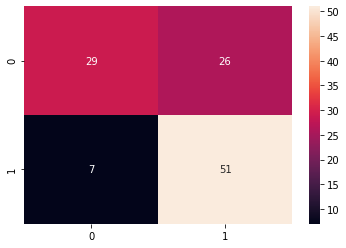

In [324]:
precision = precision_score(Y_test, Y_predicted)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, Y_predicted)
print('Recall: %f' % recall)
# f1: tp / (tp + fp + fn)
f1 = f1_score(Y_test, Y_predicted)
print('F1 score: %f' % f1)

# Matriz de confusión
cf_matrix = confusion_matrix(Y_test, Y_predicted)
sns.heatmap(cf_matrix, annot=True)

## PASO 5: Evaluación

In [325]:
# Usamos el algoritmo de scikit learn con los mismos hiperparámetros 
tree_one=tree.DecisionTreeClassifier()

# Ajustamos el modelo a nuestra data de entrenamiento
tree_one=tree_one.fit(X,Y)

Precision: 0.654545
Recall: 0.620690
F1 score: 0.637168


<AxesSubplot:>

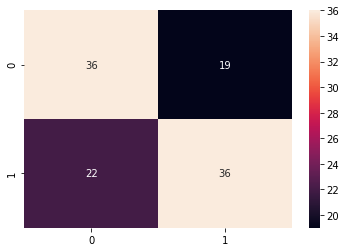

In [326]:
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score, confusion_matrix
Y_predicted = tree_one.predict(X_test)

precision = precision_score(Y_test, Y_predicted)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, Y_predicted)
print('Recall: %f' % recall)
# f1: tp / (tp + fp + fn)
f1 = f1_score(Y_test, Y_predicted)
print('F1 score: %f' % f1)

# Matriz de confusión
cf_matrix = confusion_matrix(Y_test, Y_predicted)
sns.heatmap(cf_matrix, annot=True)